In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import datetime
from os import listdir
#from os.path import isfile, join
import glob

%matplotlib inline

In [270]:
import getCTTdata
import CTTtoPandas
import importlib
importlib.reload(getCTTdata)
importlib.reload(CTTtoPandas)
metadata=getCTTdata.metadata_wairio

# Get data

In [85]:
# Initialise everything (run first time only!)
getCTTdata.getFiles(metadata,None)
_,date_deployed = getCTTdata.getStationId(metadata)
gpslist,ndlist,dlist=CTTtoPandas.getFileList(metadata['savepath'],datetime.datetime.strptime(date_deployed, "%Y-%m-%dT%H:%M:%S.000Z").date(),None)
gps,nodedata,data = CTTtoPandas.addData(None,None,None,gpslist,ndlist,dlist)
gps.sort_values(by=['gps at'],inplace=True)
data.sort_values(by=['Time'],inplace=True)
nodedata.sort_values(by=['Time'],inplace=True)
CTTtoPandas.saveDataFrames(metadata['savepath'],gps,nodedata,data)

In [68]:
# Update 
metadata=getCTTdata.metadata_zealandia
firstNewFile = getCTTdata.updateFiles(metadata)
gpslist,ndlist,dlist=CTTtoPandas.getFileList(metadata['savepath'],datetime.datetime.strptime(firstNewFile, "%Y-%m-%dT%H:%M:%S.000Z").date(),None)
gps,nodedata,data = CTTtoPandas.loadDataFrames(metadata['savepath'])
gps,nodedata,data = CTTtoPandas.addData(gps,nodedata,data,gpslist,ndlist,dlist)
gps.sort_values(by=['gps at'],inplace=True)
data.sort_values(by=['Time'],inplace=True)
nodedata.sort_values(by=['Time'],inplace=True)
CTTtoPandas.saveDataFrames(metadata['savepath'],gps,nodedata,data)

2023-06-18T09:53:56.000Z


In [263]:
# I used this one to get the first Zealandia data
#metadata=getCTTdata.metadata_zealandia
#getCTTdata.getFiles(metadata,"2023-08-29")
gpslist,ndlist,dlist=CTTtoPandas.getFileList(metadata['savepath'],datetime.datetime.strptime(firstNewFile, "%Y-%m-%dT%H:%M:%S.000Z").date(),None)
gps,nodedata,data = CTTtoPandas.addData(None,None,None,gpslist,ndlist,dlist)
gps.sort_values(by=['gps at'],inplace=True)
data.sort_values(by=['Time'],inplace=True)
nodedata.sort_values(by=['Time'],inplace=True)
CTTtoPandas.saveDataFrames(metadata['savepath'],gps,nodedata,data)

In [115]:
# This is how to load a particular timeframe and put it into a new set of dataframes
startdate = "2023-04-23"
enddate="2023-06-30"
gpslist,ndlist,dlist=CTTtoPandas.getFileList(getCTTdata.metadata['savepath'],datetime.datetime.strptime(startdate, "%Y-%m-%d").date(),datetime.datetime.strptime(enddate, "%Y-%m-%d").date())
gps,nodedata,data = CTTtoPandas.addData(None,None,None,gpslist,ndlist,dlist)
gps.sort_values(by=['gps at'],inplace=True)
data.sort_values(by=['Time'],inplace=True)
nodedata.sort_values(by=['Time'],inplace=True)
CTTtoPandas.saveDataFrames(getCTTdata.metadata['savepath'],gps,nodedata,data)

In [77]:
# This is how to add to a set of dataframes
startdate="2023-05-16"
gpslist,ndlist,dlist=CTTtoPandas.getFileList(getCTTdata.metadata['savepath'],datetime.datetime.strptime(startdate, "%Y-%m-%d").date(),None)
gps,nodedata,data = CTTtoPandas.addData(gps,nodedata,data,gpslist,ndlist,dlist)
gps.sort_values(by=['gps at'],inplace=True)
data.sort_values(by=['Time'],inplace=True)
nodedata.sort_values(by=['Time'],inplace=True)

In [81]:
# In case you end up with some rows repeated
gps.drop_duplicates(inplace=True)

# GPS locations

Nodedata holds the data from each node about battery state, GPS fixes. 
We will use the GPS info, but that's about it. 
And we should probably just store those and then assume they don't change.

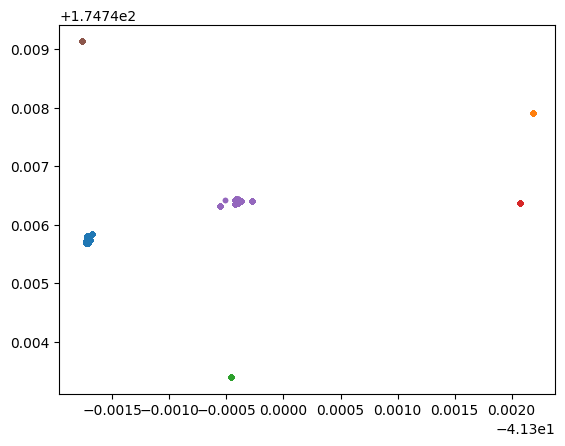

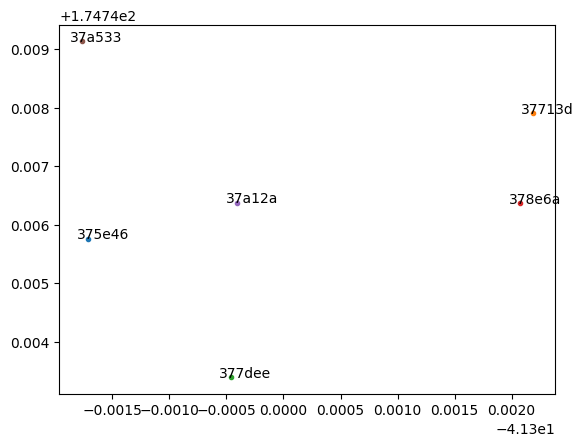

In [264]:
# Plot on map
# All data
nodes = np.unique(nodedata.NodeId)
for n in nodes:
    pl.plot(nodedata[nodedata.NodeId==n].Latitude.to_numpy(),nodedata[nodedata.NodeId==n].Longitude.to_numpy(),'.')

# Plot single point at average (remove outliers?)
# Give name
# Get the average, don't check for outliers
a = nodedata[['NodeId','Latitude','Longitude']]
avg_locns = a.groupby(['NodeId']).mean().reset_index()

#avg_locns = gps.groupby(by=['NodeId']).mean().reset_index()
avg_locns.head()
nodes = np.unique(avg_locns.NodeId)
pl.figure()
# WTF
#for n in nodes:
#    pl.plot(avg_locns[avg_locns.NodeId==n].Latitude,avg_locns[avg_locns.NodeId==n].Longitude,'.')
#    pl.text(avg_locns[avg_locns.NodeId==n].Latitude-0.0001,avg_locns[avg_locns.NodeId==n].Longitude,n)
for n in range(len(avg_locns)):
    pl.plot(avg_locns.iloc[n,1],avg_locns.iloc[n,2],'.')
    #print(avg_locns.iloc[n,1],avg_locns.iloc[n,2])
    pl.text(avg_locns.iloc[n,1]-0.0001,avg_locns.iloc[n,2],avg_locns.iloc[n,0])

# Compare with GPS

/home/marslast/.pyenv/versions/3.9.16/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


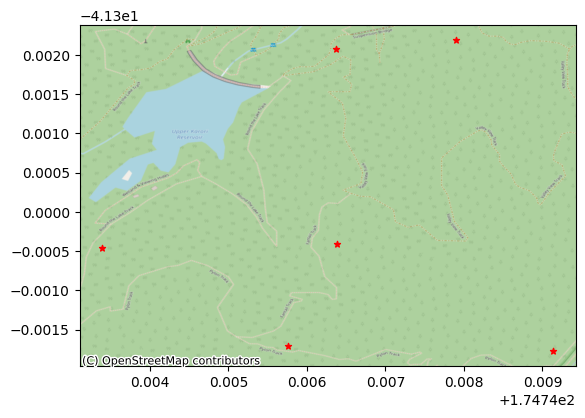

In [265]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(avg_locns.Longitude,avg_locns.Latitude)]
    
#ward = gpd.read_file(wardlink, bbox=None, mask=None, rows=None)
geo_df = gpd.GeoDataFrame(geometry = geometry)
geo_df.crs = {'init':"epsg:4326"}

ax = pl.figure().gca()

#for x,y,label in zip(avg_locns.Longitude,avg_locns.Latitude,avg_locns.NodeId):
#    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    
# plot the polygon
#ax = ward.plot(alpha=0.35, color='#d66058', zorder=1)
# plot the boundary only (without fill), just uncomment
#ax = gpd.GeoSeries(ward.to_crs(epsg=3857)['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)
#ax = gpd.GeoSeries(ward['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)

# plot the marker
ax = geo_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*', zorder=3)

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# How to add labels? annotate line fails

In [223]:
# Save those average locations as the ones we use from now on
avg_locns.to_pickle(os.path.join(getCTTdata.metadata['savepath'],'nodeLocations.pkl'))

# Beep data

Pretty much everything we want is in the data dataframe. 

In [266]:
data.dtypes

Time         object
RadioId       int64
TagId        object
TagRSSI       int64
NodeId       object
Validated     int64
dtype: object

In [267]:
data.head()

,Time,RadioId,TagId,TagRSSI,NodeId,Validated
4104,2023-08-29 01:05:36,1,4CB4AA55,-117,377dee,0
4105,2023-08-29 01:05:36,3,4CB4AA55,-117,377dee,0
4116,2023-08-29 01:42:39,2,2D872A87,-112,NaN,0
4117,2023-08-29 01:48:03,2,9E55FFF8,-112,NaN,0
4119,2023-08-29 02:22:48,3,7FCCAD4B,-116,37a12a,0


There are immense holes in this data and there are truck loads of misreads. For example, we have 10 tags that could have been out -- most weren't -- but look how many unique TagIds have been read:

In [268]:
print(len(np.unique(data[data.NodeId.notnull()].NodeId.astype(str))))
print(np.unique(data[data.NodeId.notnull()].NodeId.astype(str)))
print(len(np.unique(data[data.TagId.notnull()].TagId.astype(str))))
print(np.unique(data[data.TagId.notnull()].TagId.astype(str)))

6
['375e46' '37713d' '377dee' '378e6a' '37a12a' '37a533']
49
['00993419' '19874C66' '19FFAD99' '2AF8B355' '2D872A87' '2D99CB33'
 '2DB47F61' '3307B32D' '332D3487' '3366D555' '34E6E607' '4BB3F887'
 '4C78662A' '4C7FF84B' '4CB4AA55' '6155AD9E' '664B662D' '664B66AD'
 '664BE62D' '664BE6AD' '66CB662D' '66CBE62D' '78B31ECB' '7F1907B3'
 '7FCCAD4B' '80332DE1' '80CCD580' '877FCB9E' '87AD2A4C' '9E55FFF8'
 'AA34349E' 'AAB3B32D' 'AD78071E' 'B307FFB3' 'B3E61E87' 'CC199ECC'
 'CCADE1CB' 'D5330099' 'E19EF87F' 'E1B36680' 'E64B662D' 'E6786633'
 'E6FFAA1E' 'F880612D' 'F8D28707' 'FF2D7887' 'FF33D21E' 'FFB4FF87'
 'FFFFCB2D']


In [269]:
tags = np.unique(data.TagId.astype(str))
for i in tags:
    if len(np.where(data.TagId==i)[0]) > 100:
        print(i,len(np.where(data.TagId==i)[0]))

664B662D 4034


In [198]:
tags = np.unique(data.TagId)
for i in tags:
    if len(np.where(data.TagId==i)[0]) > 100:
        print(i,len(np.where(data.TagId==i)[0]))

2A194B78 53403
2D2D6166 12653
332D7855 271949
332D78D5 579
332DF855 960
33AD7855 588
3466612D 58958
346661AD 161
3466E12D 150
34E6612D 150
4C664C66 15151
B32D7855 564
B466612D 157


Tags Ellen put out (24/4/23 -- 19/05/23)
19523434
3466612D
66556134

Rat tags:
2A194B78 19/5/23 1530
332D7855 24/5/23 1500
19523434 21/6/23 1530

Stephen H
2D2D6166 1/6/23

Let's reduce the dataframe to those exactly for now -- later worth seeing if there are errors in detections

In [271]:
ourtags = ['19523434','3466612D','66556134','2A194B78','332D7855','19523434','2D2D6166']

In [272]:
beeps = data[data.TagId.isin(ourtags)]

In [273]:
beeps.head()

,Time,RadioId,TagId,TagRSSI,NodeId,Validated


In [205]:
# These are the tags that were detected -- 2 rats, 2 tests
detected = np.unique(beeps.TagId)
print(detected)
for i in detected:
    print(len(np.where(beeps==i)[0]))

['2A194B78' '2D2D6166' '332D7855' '3466612D']
53403
12653
271949
58958


In [145]:
# So there are a few misreads on each. Should we correct them?
from scipy.spatial.distance import hamming
x = list(np.unique(beeps.TagId)[2])
#0.125 is 1 character, 0.25 is 2 characters
for i in tags:
    if hamming(list(i),x) < 0.26:
        print(i)

072D7855
192D7855
33197855
332A7855
332AF855
332D1955
332D1E55
332D5255
332D6155
332D7807
332D7819
332D781E
332D782A
332D7834
332D784C
332D7852
332D7855
332D7861
332D7878
332D787F
332D78AA
332D78B4
332D78D5
332D78FF
332DAA55
332DF855
332DF8D5
33347855
334B7855
334C7855
33617855
33667855
33877855
33AD7855
33AD78D5
33ADF855
342D7855
612D7855
7F2D7855
B32D7855
B32D78D5
B32DF855
B32F7855
B3AD7855


In [194]:
# Can hopefully do this more efficiently with apply()
for i in ourtags:
    x = list(i)
    for j in range(np.shape(data)[0]):
        # This seems to be failing -- first test 
        if (not(data.TagId[j] in ourtags)) & (hamming(list(data.TagId[j]),x) < 0.26):
            #print(j,data.iloc[j,2],i)
            data.iloc[j,2] = i


In [208]:
for istr in ourtags:
    i = list(istr)
    data.TagId.apply(lambda x: istr if ((hamming(list(x),i) > 0) & (hamming(list(x),i) <0.26)) else x)

In [157]:
tags = np.unique(data.TagId)
len(tags)

16790

In [206]:
beeps.to_pickle(os.path.join(getCTTdata.metadata['savepath'],'beeps.pkl'))

In [212]:
data.head()

,Time,RadioId,TagId,TagRSSI,NodeId,Validated
114184,2023-04-20 19:12:58,1,5207349E,-115,376e52,0
114182,2023-04-20 19:13:32,3,35DE57EF,-96,NaN,0
114183,2023-04-20 19:15:09,5,A06E6A7A,-111,NaN,0
114185,2023-04-20 19:19:50,3,F64A8E6B,-109,NaN,0
114186,2023-05-11 23:21:02,1,3466612D,-109,376f0d,0


In [214]:
print(data.TagId[8691],ourtags[1],hamming(list(data.TagId[8691]),list(ourtags[1])))

34E6612D 3466612D 0.125


In [ ]:
# Sort out the apply
# Save the data
# Then a new notebook -- just load the locations and the beeps
# Ideally, some beeps would be detected by multiple nodes -- check for it
# Otherwise, cluster in time -- what quanta?
# Then think about localisation